# Introduction
**Todo:** Paragraph(s)

# MP3 & AAC Codecs
**Todo:** A paragraph for history of MP3 and AAC codecs

As can be seen in the flow chart below, MP3 and AAC codecs use some similar steps to generate compressed audio and similar steps to decode the compressed bitstream back to audio PCM signal. These similar steps are: Modified Discrete Cosine Transform (MDCT), Scaling, Quantization, and [Huffman Coding](https://en.wikipedia.org/wiki/Huffman_coding). Therefore, we will be focusing more on those three and specially MDCT as the last two are well known in almost every compression scheme including zip or gz. Among differences of MP3 and AAC codecs, it can be seen that MP3 codec is using [Polyphase Quadrature Filter (PQF)](https://en.wikipedia.org/wiki/Polyphase_quadrature_filter) before the MDCT, and [Alias Reduction](https://en.wikipedia.org/wiki/Aliasing) after the MDCT. Contrarily, AAC codec is using [Temporal Noise Shaping (TNS)](https://en.wikipedia.org/wiki/Noise_shaping) and [Perceptual 
Noise Substitution (PNS)](https://ccrma.stanford.edu/~kapilkm/422/Audio%20Compression%20using%20Entropy%20Coding%20and%20PNS-1.pdf).
![MP3 and AAC Encoders and Decoders](./images/mp3aac.svg)

**Todo:** A paragraph about ffmpeg and two audio samples (piano and voice)

In [1]:
!ffmpeg -y -i piano.wav piano.mp3 2> /dev/null
!ffmpeg -y -i piano.wav piano.aac 2> /dev/null
!ffmpeg -y -i piano.mp3 piano_regenerated_mp3.wav 2> /dev/null
!ffmpeg -y -i piano.aac piano_regenerated_aac.wav 2> /dev/null

In [2]:
import os
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
from ipywidgets import widgets, Layout

def wave_specgram(wav_file, title, duration=None):    
    data, rate = sf.read(wav_file)
    if duration:
        data = data[:rate*duration]    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.specgram(data, cmap=plt.cm.gist_heat, Fs=rate)
    
    widget = widgets.Output()
    with widget:
        display(Audio(wav_file))
    return widget

def calc_ratio(original_file, other_file):
    original_file_size = os.path.getsize(original_file)
    other_file_size = os.path.getsize(other_file)
    return round(other_file_size*100/original_file_size, 2)

/home/matin/Projects/DirectedStudy/venv/lib64/python3.10/site-packages/matplotlib/axes/_axes.py:7580: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


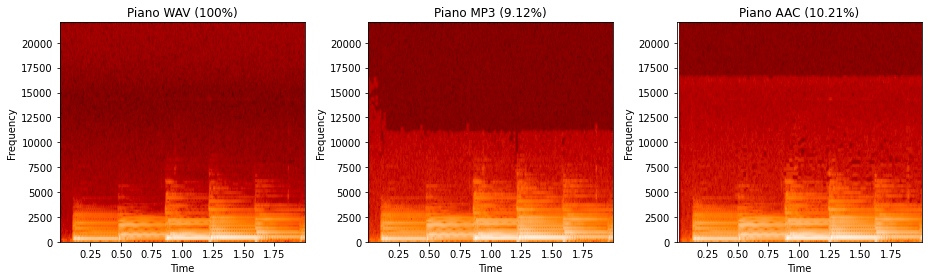

In [3]:
plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1)
w1 = wave_specgram("piano.wav", "Piano WAV (100%)", duration=2)
plt.subplot(1, 3, 2)
w2 = wave_specgram("piano_regenerated_mp3.wav", f"Piano MP3 ({calc_ratio('piano.wav','piano.mp3')}%)", duration=2)
plt.subplot(1, 3, 3)
w3 = wave_specgram("piano_regenerated_aac.wav", f"Piano AAC ({calc_ratio('piano.wav','piano.aac')}%)", duration=2)
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox([w1, w2, w3], layout=box_layout)

**Todo:** A paragraph describing what can be seen in the piano spectogram.

In [4]:
!ffmpeg -y -i voice.wav voice.mp3 2> /dev/null
!ffmpeg -y -i voice.wav voice.aac 2> /dev/null
!ffmpeg -y -i voice.mp3 voice_regenerated_mp3.wav 2> /dev/null
!ffmpeg -y -i voice.aac voice_regenerated_aac.wav 2> /dev/null

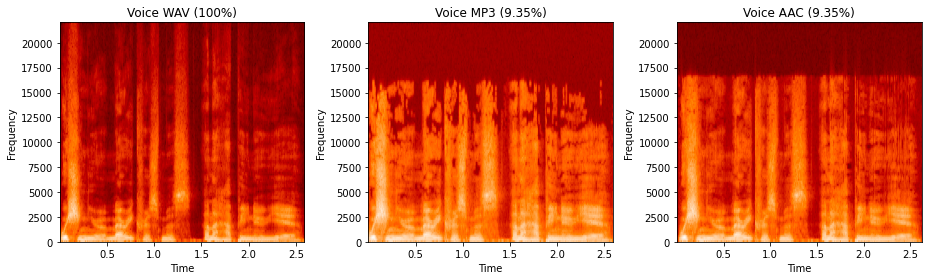

In [5]:
plt.figure(figsize=(13,4))
plt.subplot(1, 3, 1)
w1 = wave_specgram("voice.wav", "Voice WAV (100%)")
plt.subplot(1, 3, 2)
w2 = wave_specgram("voice_regenerated_mp3.wav", f"Voice MP3 ({calc_ratio('voice.wav','voice.mp3')}%)")
plt.subplot(1, 3, 3)
w3 = wave_specgram("voice_regenerated_aac.wav", f"Voice AAC ({calc_ratio('voice.wav','voice.mp3')}%)")
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox([w1, w2, w3], layout=box_layout)

**Todo:** A paragraph describing what can be seen in the piano spectogram.

# Fourier Transform
**Todo:** A paragraph as a reminder of Fourier series, Fourier transform, and discrete cosine transform: 

\begin{aligned} s_{\scriptscriptstyle N}(x)={\frac {A_{0}}{2}}+\sum _{n=1}^{N}A_{n}\cdot \cos \left({\tfrac {2\pi }{P}}nx-\varphi _{n}\right).\end{aligned}

The animation below shows an example of fourier transformation:
![](https://upload.wikimedia.org/wikipedia/commons/2/2b/Fourier_series_and_transform.gif)

The animation below shows the convergence of equation with increment of N value:
![](https://upload.wikimedia.org/wikipedia/commons/3/37/Example_of_Fourier_Convergence.gif)

# MDCT
**Todo:** A paragraph about the Modified Discrete Cosine Transform (MDCT). 

\begin{aligned} X_{k}=\sum _{{n=0}}^{{2N-1}}x_{n}\cos \left[{\frac  {\pi }{N}}\left(n+{\frac  {1}{2}}+{\frac  {N}{2}}\right)\left(k+{\frac  {1}{2}}\right)\right].\end{aligned}

Wikipedia says: a transform based on the type-IV discrete cosine transform (DCT-IV), with the additional property of being lapped: it is designed to be performed on consecutive blocks of a larger dataset, where subsequent blocks are overlapped so that the last half of one block coincides with the first half of the next block. This overlapping, in addition to the energy-compaction qualities of the DCT, makes the MDCT especially attractive for signal compression applications, since it helps to avoid artifacts stemming from the block boundaries. As a result of these advantages, the MDCT is the most widely used lossy compression technique in audio data compression. It is employed in most modern audio coding standards, including MP3, Dolby Digital (AC-3), Vorbis (Ogg), Windows Media Audio (WMA), ATRAC, Cook, Advanced Audio Coding (AAC), High-Definition Coding (HDC), LDAC, Dolby AC-4, and MPEG-H 3D Audio, as well as speech coding standards such as AAC-LD (LD-MDCT), G.722.1, G.729.1, CELT, and Opus.

**Todo:** A paragraph about practically trying MDCT using artificial signals, starting with a constant signal.

In [6]:
import mdct
import numpy as np
import matplotlib.pyplot as plt

def generate_mdct_const(rate, duration, output_wav_file):
    data = np.zeros((512, rate*duration//512),dtype=np.float64)    
    data[15,:] = 1000
    return data

**Todo:** Short description about a sine signal.

In [7]:
def generate_mdct_sine(rate, duration, output_wav_file):
    data = np.zeros((512, rate*duration//512),dtype=np.float64)
    for i in range(data.shape[1]):
        data[int(30 + 20*np.sin(np.deg2rad(5*i))),i] = 1000
    return data
  

**Todo:** Short description about drawing the MDCT spectogram.

In [8]:
def draw_mdct_spectogram(data, rate, duration, title):
    data = data[:,:rate*duration//512]
    data = np.float64(data)
    eps = 1e-10
    data = np.log(eps + data ** 2)
    data = np.flipud(data)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency Index')
    plt.imshow(data, aspect='auto', extent=[0,duration,0,512], cmap=plt.cm.gist_heat)     

Now let's put it together.

/home/matin/Projects/DirectedStudy/venv/lib/python3.10/site-packages/stft/utils.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]
/home/matin/Projects/DirectedStudy/venv/lib/python3.10/site-packages/stft/utils.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicetuple]


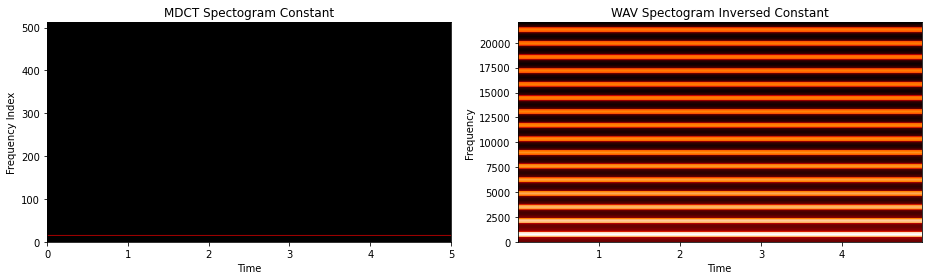

Output()

In [9]:
plt.figure(figsize=(13,4))
data = generate_mdct_const(44100, 5, "mdct_const.wav")
plt.subplot(1, 2, 1)
draw_mdct_spectogram(data, 44100, 5, "MDCT Spectogram Constant")

sig2 = mdct.imdct(data)
sf.write("mdct_const.wav", sig2, 44100)
plt.subplot(1, 2, 2)
a = wave_specgram("mdct_const.wav", 'WAV Spectogram Inversed Constant')

plt.tight_layout()
plt.show()
display(a)

**Todo:** A paragraph describing what is observabale in the spectogram above.

/home/matin/Projects/DirectedStudy/venv/lib64/python3.10/site-packages/matplotlib/axes/_axes.py:7580: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


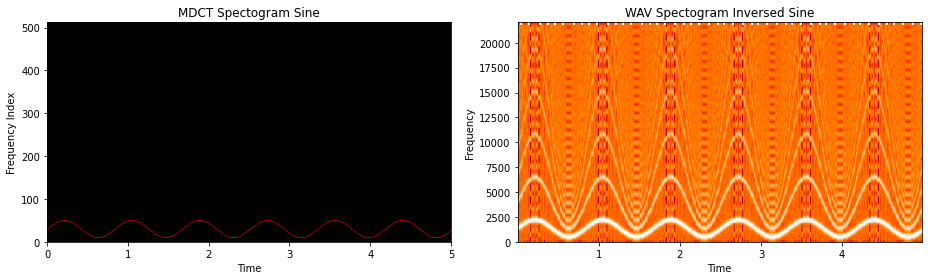

Output()

In [10]:
plt.figure(figsize=(13,4))
data = generate_mdct_sine(44100, 5, "mdct_sine.wav")
plt.subplot(1, 2, 1)
draw_mdct_spectogram(data, 44100, 5, "MDCT Spectogram Sine")

sig2 = mdct.imdct(data)
sf.write("mdct_sine.wav", sig2, 44100)
plt.subplot(1, 2, 2)
a = wave_specgram("mdct_sine.wav", 'WAV Spectogram Inversed Sine')

plt.tight_layout()
plt.show()
display(a)

**Todo:** A paragraph describing what is observabale in the spectogram above.

# Encoder
**Big To do:** Paragraphs describing how to make a compression. Need to describe each step: 1) High Freq Cut, 2) Float16, 3) Rounding Floats, 4) Removing Low Intensities, 5) using numpy's savez_compressed which already has scaling and huffman coding inside it.

In [11]:
import soundfile as sf

def encode(input_wav_file, output_npz_name):
    data, rate = sf.read(input_wav_file)
    plt.figure(figsize=(13,4))
    
    r = mdct.mdct(data)
    np.savez_compressed(f'{output_npz_name}0.npz', rate=rate, data=r)
    plt.subplot(1, 5, 1)
    draw_mdct_spectogram(r, rate, 2, 'Original (100%)')

    r[150:511, :] = 0
    np.savez_compressed(f'{output_npz_name}1.npz', rate=rate, data=r)
    plt.subplot(1, 5, 2)
    draw_mdct_spectogram(r, rate, 2, f'High Freq Cut ({calc_ratio(input_wav_file,f"{output_npz_name}1.npz")}%)')
    
    r = np.float16(r)
    np.savez_compressed(f'{output_npz_name}2.npz', rate=rate, data=r)
    plt.subplot(1, 5, 3)
    draw_mdct_spectogram(r, rate, 2, f'Float16 ({calc_ratio(input_wav_file,f"{output_npz_name}2.npz")}%)')

    r = np.round(r, decimals=2)
    np.savez_compressed(f'{output_npz_name}3.npz', rate=rate, data=r)
    plt.subplot(1, 5, 4)
    draw_mdct_spectogram(r, rate, 2, f'Round Floats ({calc_ratio(input_wav_file,f"{output_npz_name}3.npz")}%)')

    r = np.where(abs(r) < 0.1, 0, r)
    np.savez_compressed(f'{output_npz_name}4.npz', rate=rate, data=r)
    plt.subplot(1, 5, 5)
    draw_mdct_spectogram(r, rate, 2, f'Remove Low Intensities ({calc_ratio(input_wav_file,f"{output_npz_name}4.npz")}%)')
    
    plt.tight_layout()
    plt.show()

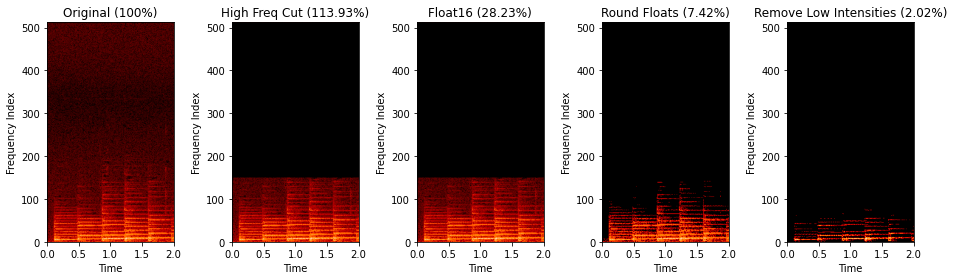

In [12]:
encode('piano.wav', 'piano_npz')

**Todo:** Describe what is observable in the spectograms above.

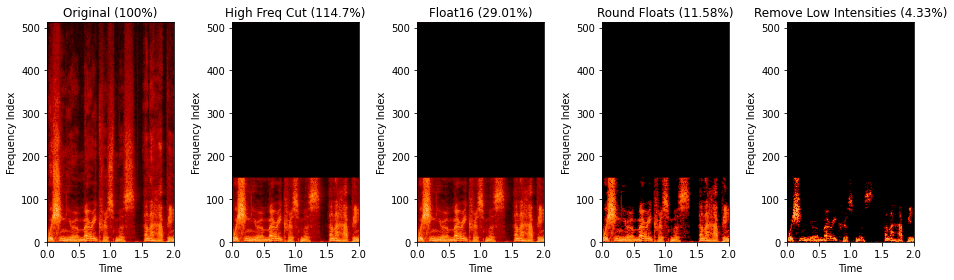

In [13]:
encode('voice.wav', 'voice_npz')

**Todo:** Describe what is observable in the spectograms above.

# Decoder

**Todo:** A paragraph about the decoder.

In [14]:
def decode(input_npz_file, output_wav_file):
    npz = np.load(input_npz_file)
    rate = npz['rate']
    sig2 = mdct.imdct(npz['data'])
    sf.write(output_wav_file, sig2, rate)

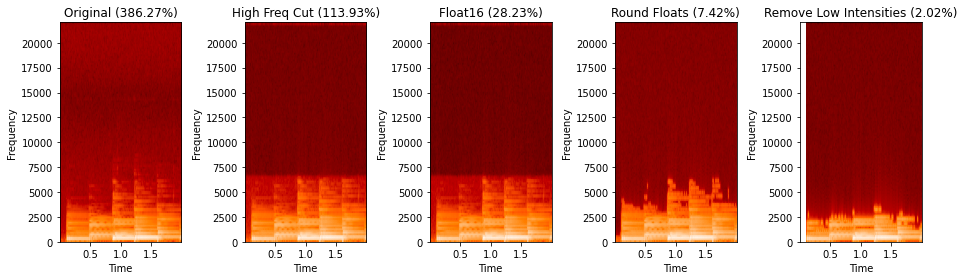

In [15]:
plt.figure(figsize=(13,4))
stages = ['Original', 'High Freq Cut', 'Float16', 'Round Floats', 'Remove Low Intensities']
audio_widgets = []

for i in range(len(stages)):
    plt.subplot(1, len(stages), i+1)
    decode(f'piano_npz{i}.npz', f'piano_regenerated_npz{i}.wav')
    widget = wave_specgram(f'piano_regenerated_npz{i}.wav', f"{stages[i]} ({calc_ratio('piano.wav',f'piano_npz{i}.npz')}%)", duration=2)
    audio_widgets.append(widget)
    
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox(audio_widgets, layout=box_layout)

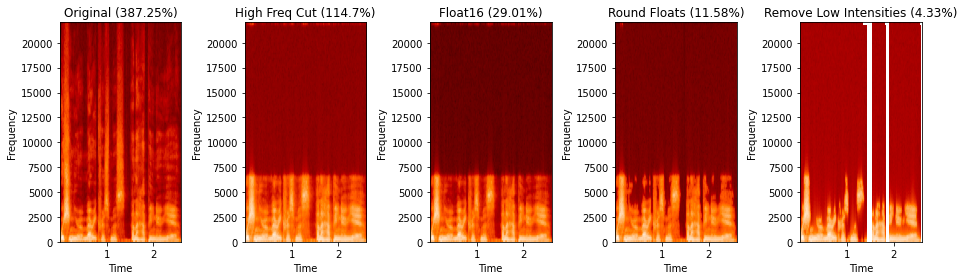

In [16]:
plt.figure(figsize=(13,4))
stages = ['Original', 'High Freq Cut', 'Float16', 'Round Floats', 'Remove Low Intensities']
audio_widgets = []

for i in range(len(stages)):
    plt.subplot(1, len(stages), i+1)
    decode(f'voice_npz{i}.npz', f'voice_regenerated_npz{i}.wav')
    widget = wave_specgram(f'voice_regenerated_npz{i}.wav', f"{stages[i]} ({calc_ratio('voice.wav',f'voice_npz{i}.npz')}%)")
    audio_widgets.append(widget)
    
plt.tight_layout()
plt.show()
box_layout = Layout(display='flex',flex_flow='row',justify_content='space-around',width='auto')
widgets.HBox(audio_widgets, layout=box_layout)

**Todo:** Describe what is observable in the spectograms above.
# Conclusion
**Todo:** Some paragraphs here.

# References (10-20)

Ravelli, Emmanuel, Gal Richard, and Laurent Daudet. “Union of MDCT Bases for Audio Coding.” IEEE Transactions on Audio, Speech, and Language Processing 16, no. 8 (November 2008): 1361–72. https://doi.org/10.1109/TASL.2008.2004290.

Ravelli, Emmanuel, Gaël Richard, and Laurent Daudet. “Audio Signal Representations for Indexing in the Transform Domain.” IEEE Transactions on Audio, Speech, and Language Processing 18, no. 3 (March 2010): 434–46. https://doi.org/10.1109/TASL.2009.2025099.


**To Read:**

Stephen. Perceptual Coding In Python. Matlab, 2021. https://github.com/stephencwelch/Perceptual-Coding-In-Python/blob/2993f57570663768c02745019185091a23f021fe/PEAQ.md.

“MUSHRA.” In Wikipedia, March 26, 2021. https://en.wikipedia.org/w/index.php?title=MUSHRA&oldid=1014261385.

“Karlheinz Brandenburg.” Accessed November 18, 2021. https://scholar.google.de/citations?user=a9nMg8sAAAAJ&hl=de.
